## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable = ['ner', 'parser']) #'tagger', 'textcat'
import seaborn as sns
import matplotlib.pyplot as plt
### import necessary libraries
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from pprint import pprint
sns.set(style='whitegrid')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('Dataset/complaints-2021-05-14_08_16.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

#### Since we want to understand the customer complaint we will only be looking at the complaints column

In [5]:
df['_source.complaint_what_happened']

0                                                         
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                         
4                                                         
                               ...                        
78308                                                     
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: _source.complaint_what_happened, Length: 78313, dtype: object

In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
#Assign new column names
df.rename(columns={'_source.complaint_what_happened':'complaints', '_source.product':'tag'}, inplace=True)

In [8]:
df = df[['complaints', 'tag']]
df

,complaints,tag
0,,Debt collection
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
3,,Mortgage
4,,Credit card or prepaid card
...,...,...
78308,,Checking or savings account
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Credit card or prepaid card
78310,I am not familiar with XXXX pay and did not un...,Checking or savings account
78311,I have had flawless credit for 30 yrs. I've ha...,Credit card or prepaid card


#### There are few blank rows in the complaints columns and these cannot be used. hence we would be removing these rows.

In [9]:
#Assign nan in place of blanks in the complaints column
df['complaints'] = df['complaints'].replace(r'^\s*$', np.nan, regex=True)
df['complaints']

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaints, Length: 78313, dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   complaints  21072 non-null  object
 1   tag         78313 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [11]:
#Remove all rows where complaints column is nan
df = df[~(df['complaints'].isna())]
df

,complaints,tag
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,Checking or savings account
...,...,...
78303,After being a Chase Card customer for well ove...,Credit card or prepaid card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Credit card or prepaid card
78310,I am not familiar with XXXX pay and did not un...,Checking or savings account
78311,I have had flawless credit for 30 yrs. I've ha...,Credit card or prepaid card


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
text = df['complaints'][11]
text

'On XX/XX/2018, while trying to book a XXXX  XXXX  ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX  offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happene

In [14]:
text1 = re.sub('{|}|/','', text) # Remove brackets and / sign
text1 = re.sub('\d','', text1) # Remove any numbers
text1 = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text1) # Remove punctuation
text1 = re.sub(r'\s+', ' ',text1) # Remove multiple space
text1 = re.sub(r'\n', '', text1) # Remove line breaks
text1 = text1.lower() # Convert to lowercase
text1 = text1.strip() # Remove leading and trailing spaces
text1

'on xxxx while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than mins after putti

In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text (text):
    #text = re.sub('XX*','', text) # Remove any characted with XX
    text = re.sub('{|}|/','', text) # Remove brackets and / sign
    text = re.sub('\d','', text) # Remove any numbers
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'\s+', ' ',text) # Remove multiple space
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = text.lower() # Convert to lowercase
    text = text.strip() # Remove leading and trailing spaces
    
    return text


In [16]:
# Apply data cleaning to the complaints_what_happened column

df['complaints'] = df['complaints'].apply(clean_text)
df

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9500\2229880330.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaints,tag
1,good morning my name is xxxx xxxx and i apprec...,Debt collection
2,i upgraded my xxxx xxxx card in xxxx and was t...,Credit card or prepaid card
10,chase card was reported on xxxx however fraudu...,"Credit reporting, credit repair services, or o..."
11,on xxxx while trying to book a xxxx xxxx ticke...,"Credit reporting, credit repair services, or o..."
14,my grand son give me check for i deposit it in...,Checking or savings account
...,...,...
78303,after being a chase card customer for well ove...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,Credit card or prepaid card
78310,i am not familiar with xxxx pay and did not un...,Checking or savings account
78311,i have had flawless credit for yrs i ve had ch...,Credit card or prepaid card


In [17]:
#Write your function to Lemmatize the texts
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str

In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame({'complaints': df['complaints'], 'lemma': df['complaints'].apply(lemmatization)})

In [20]:
df_clean

,complaints,lemma
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...
11,on xxxx while trying to book a xxxx xxxx ticke...,on xxxx while trying to book a xxxx xxxx ticke...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...
...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...


In [21]:
#Write your function to extract the POS tags 

def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_pos_tags(x['lemma']), axis=1)

In [22]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemma,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...,agent anniversary date agent information order...
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...,chase card application identity consent servic...
11,on xxxx while trying to book a xxxx xxxx ticke...,on xxxx while trying to book a xxxx xxxx ticke...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...
...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




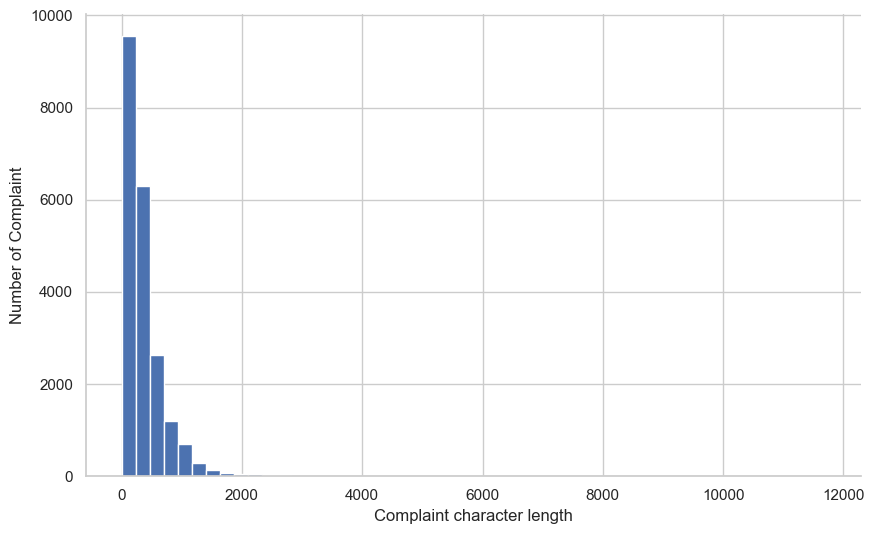

In [23]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_POS_removed_len'] = df_clean['complaint_POS_removed'].apply(lambda x: len(x))

plt.figure(figsize=(10,6))
plt.hist(df_clean['complaint_POS_removed_len'], bins = 50)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();


#### Find the top 40 words by frequency among all the articles after processing the text.

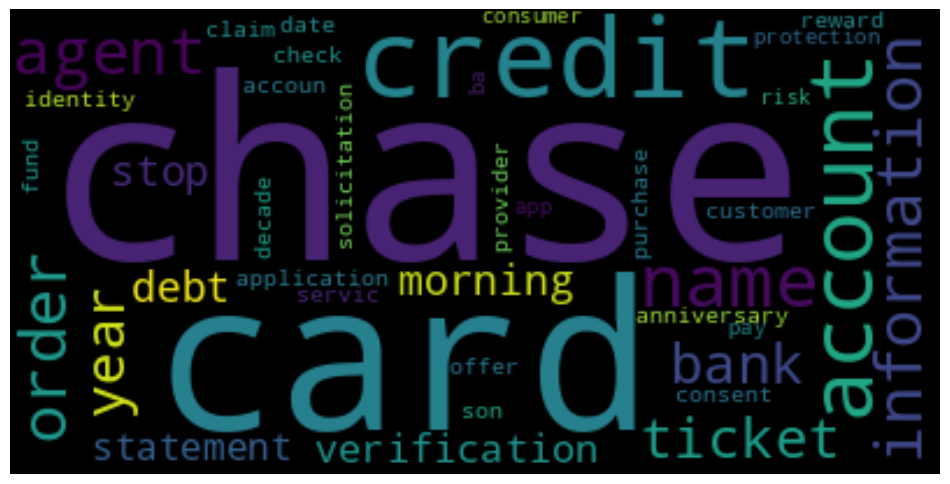

In [24]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [25]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [26]:
from nltk import everygrams

In [27]:
text_list = ' '.join(list(df_clean['Complaint_clean'])).split()
text_list = [text for text in text_list if text not in stopwords.words('english')]

In [28]:
def create_grams(text_list, n):
    grams = list(everygrams(text_list, n, n))
    if n == 1:
        list_of_tuples = [tup[0] for tup in grams]
    else:
        list_of_tuples = [tuple(sorted(tup)) for tup in grams]

    df_freq = pd.DataFrame({'data': list_of_tuples})
    df_gram = df_freq.groupby('data').value_counts()
    df_gram = df_gram.sort_values(ascending=False)
    df_gram = df_gram.reset_index()
    df_gram.columns = ['Data', 'count']
    return df_gram

In [29]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
df_unigram = create_grams(text_list, 1)
df_unigram.head(30)

,Data,count
0,chase,61978
1,account,46354
2,credit,32262
3,card,29913
4,payment,21215
5,bank,17876
6,time,16266
7,day,13165
8,charge,12104
9,money,11991


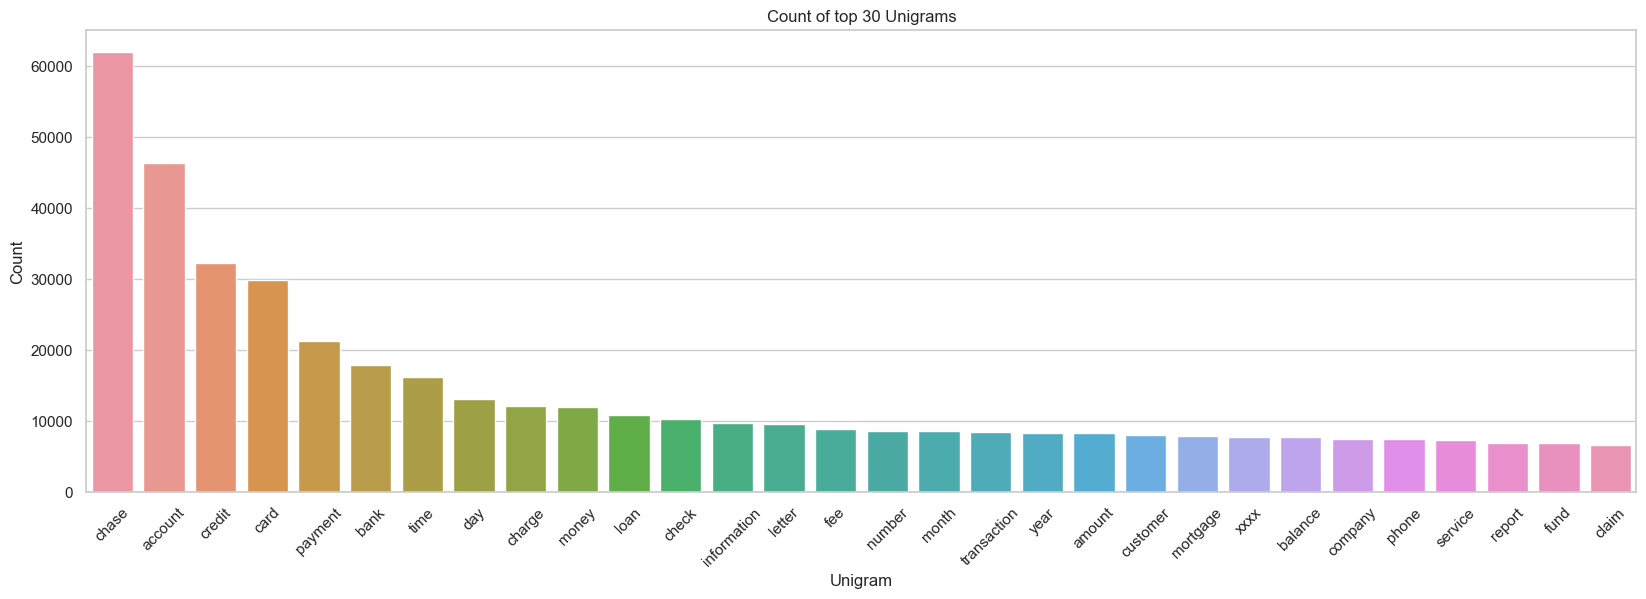

In [30]:
# Plotting top 30 Unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram[:30]['Data'], y=df_unigram[:30]['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [31]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,Data,count
0,chase,61978
1,account,46354
2,credit,32262
3,card,29913
4,payment,21215
5,bank,17876
6,time,16266
7,day,13165
8,charge,12104
9,money,11991


In [32]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
df_bigram = create_grams(text_list, 2)
df_bigram.head(30)

,Data,count
0,"(card, credit)",13760
1,"(account, chase)",6769
2,"(credit, report)",4343
3,"(chase, credit)",4014
4,"(card, chase)",3829
5,"(bank, chase)",3762
6,"(account, checking)",3725
7,"(account, bank)",3191
8,"(customer, service)",3047
9,"(account, account)",2564


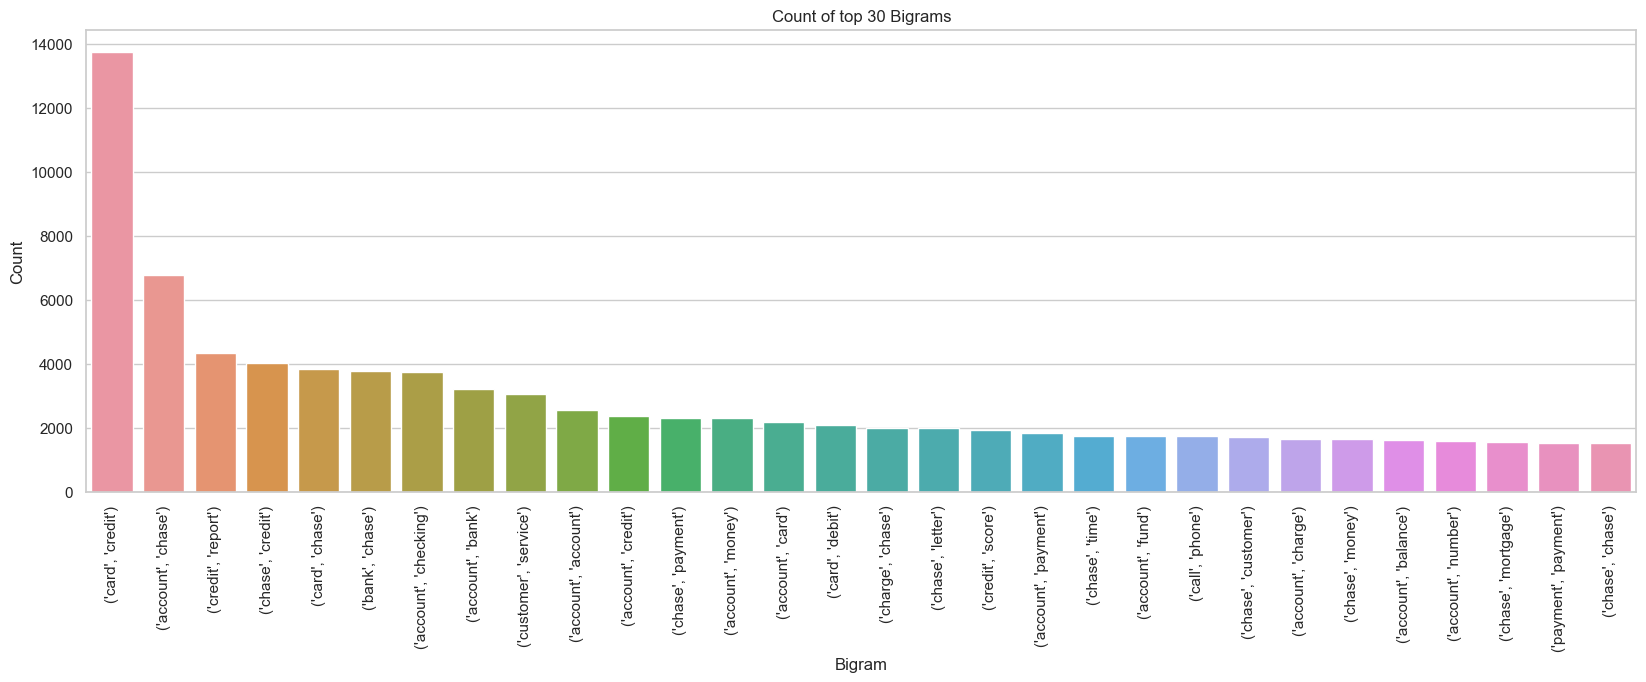

In [33]:
# Plotting top 30 Unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_bigram[:30]['Data'], y=df_bigram[:30]['count'])
plt.xticks(rotation=90)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Count of top 30 Bigrams")
plt.show()

In [34]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,Data,count
0,"(card, credit)",13760
1,"(account, chase)",6769
2,"(credit, report)",4343
3,"(chase, credit)",4014
4,"(card, chase)",3829
5,"(bank, chase)",3762
6,"(account, checking)",3725
7,"(account, bank)",3191
8,"(customer, service)",3047
9,"(account, account)",2564


In [35]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
df_trigram = create_grams(text_list, 3)
df_trigram.head(30)

,Data,count
0,"(card, chase, credit)",3610
1,"(account, card, credit)",1660
2,"(card, company, credit)",1165
3,"(account, chase, checking)",998
4,"(account, bank, chase)",789
5,"(card, card, credit)",756
6,"(credit, inquiry, report)",746
7,"(chase, customer, service)",719
8,"(account, account, chase)",710
9,"(card, credit, credit)",690


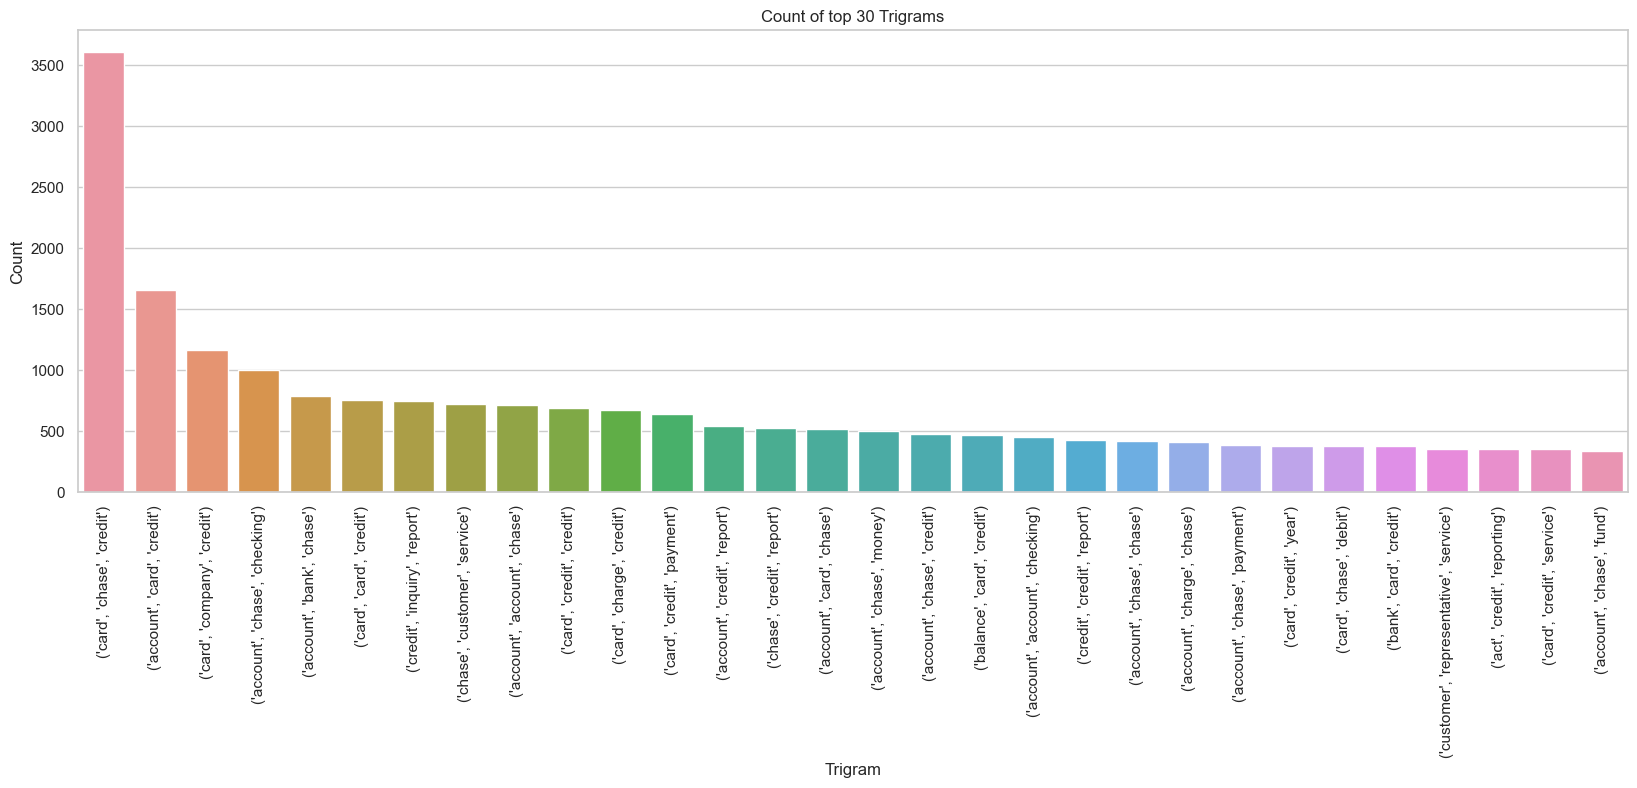

In [36]:
# Plotting top 30 Unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_trigram[:30]['Data'], y=df_trigram[:30]['count'])
plt.xticks(rotation=90)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Count of top 30 Trigrams")
plt.show()

In [37]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,Data,count
0,"(card, chase, credit)",3610
1,"(account, card, credit)",1660
2,"(card, company, credit)",1165
3,"(account, chase, checking)",998
4,"(account, bank, chase)",789
5,"(card, card, credit)",756
6,"(credit, inquiry, report)",746
7,"(chase, customer, service)",719
8,"(account, account, chase)",710
9,"(card, credit, credit)",690


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [38]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [39]:
#All masked texts has been removed
df_clean

,complaints,lemma,complaint_POS_removed,complaint_POS_removed_len,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,125,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...,agent anniversary date agent information order...,95,agent anniversary date agent information order...
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...,chase card application identity consent servic...,73,chase card application identity consent servic...
11,on xxxx while trying to book a xxxx xxxx ticke...,on xxxx while trying to book a xxxx xxxx ticke...,ticket offer ticket reward card information of...,375,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,157,son check chase account fund chase bank accoun...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,197,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...,601,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase bank app chase year ba...,642,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...,520,credit yr chase credit card chase freedom prob...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [40]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [41]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [42]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [43]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [44]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

5767

In [45]:
H = nmf_model.components_ #Topic term matrix

In [46]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,chase,fund,checking,day,deposit,branch,transaction,number,fee,claim,business
Topic 2,card,charge,chase,credit,dispute,purchase,transaction,fraud,service,merchant,time,fee,balance,company,customer
Topic 3,payment,balance,fee,month,statement,day,time,auto,credit,chase,date,year,account,error,car
Topic 4,credit,report,inquiry,card,account,score,bureau,company,debt,information,reporting,identity,application,theft,limit
Topic 5,loan,mortgage,chase,home,modification,property,year,letter,time,document,rate,foreclosure,house,sale,information


In [47]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([4, 0, 1, ..., 3, 2, 2], dtype=int64)

In [48]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [49]:
df_clean.head()

,complaints,lemma,complaint_POS_removed,complaint_POS_removed_len,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,125,morning name stop debt verification statement ...,4
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...,agent anniversary date agent information order...,95,agent anniversary date agent information order...,0
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...,chase card application identity consent servic...,73,chase card application identity consent servic...,1
11,on xxxx while trying to book a xxxx xxxx ticke...,on xxxx while trying to book a xxxx xxxx ticke...,ticket offer ticket reward card information of...,375,ticket offer ticket reward card information of...,3
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,157,son check chase account fund chase bank accoun...,0


In [51]:
#Print the first 5 Complaint for each of the Topics
# Setting max rows and columns
df_clean_grouped=df_clean.groupby('Topic').head(5)
df_clean_grouped = df_clean_grouped.sort_values('Topic')[['Complaint_clean', 'Topic']]
df_clean_grouped.to_csv('df_clean_grouped.csv', index=None)
df_clean_grouped

,Complaint_clean,Topic
27,account code bonus term everything account dep...,0
2,agent anniversary date agent information order...,0
14,son check chase account fund chase bank accoun...,0
17,notice chase account debit card branch custome...,0
24,account chase auto,0
10,chase card application identity consent servic...,1
45,purchase amount transaction dispute case charg...,1
21,payment retailer chase pay chase website scam ...,1
40,sofa love seat table chair debit card bank cla...,1
32,chase amazon card catering order brother funer...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [52]:
#Create the dictionary of Topic names and Topics
Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others", 3:"Theft/Dispute reporting", 4:"Mortgages/loans" }
Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]
Topic_names_reverse = { "Bank account services":0, "Credit card / Prepaid card":1, "Others":2, "Theft/Dispute reporting":3, "Mortgages/loans":4 }

In [53]:
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)
df_clean

,complaints,lemma,complaint_POS_removed,complaint_POS_removed_len,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,125,morning name stop debt verification statement ...,Mortgages/loans
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...,agent anniversary date agent information order...,95,agent anniversary date agent information order...,Bank account services
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...,chase card application identity consent servic...,73,chase card application identity consent servic...,Credit card / Prepaid card
11,on xxxx while trying to book a xxxx xxxx ticke...,on xxxx while trying to book a xxxx xxxx ticke...,ticket offer ticket reward card information of...,375,ticket offer ticket reward card information of...,Theft/Dispute reporting
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,157,son check chase account fund chase bank accoun...,Bank account services
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,197,chase card customer decade solicitation credit...,Credit card / Prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...,601,credit card provider claim purchase protection...,Credit card / Prepaid card
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase bank app chase year ba...,642,pay risk consumer chase bank app chase year ba...,Theft/Dispute reporting
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...,520,credit yr chase credit card chase freedom prob...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [54]:
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names_reverse)
df_clean

,complaints,lemma,complaint_POS_removed,complaint_POS_removed_len,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,125,morning name stop debt verification statement ...,4
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...,agent anniversary date agent information order...,95,agent anniversary date agent information order...,0
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...,chase card application identity consent servic...,73,chase card application identity consent servic...,1
11,on xxxx while trying to book a xxxx xxxx ticke...,on xxxx while trying to book a xxxx xxxx ticke...,ticket offer ticket reward card information of...,375,ticket offer ticket reward card information of...,3
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,157,son check chase account fund chase bank accoun...,0
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,197,chase card customer decade solicitation credit...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...,601,credit card provider claim purchase protection...,1
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase bank app chase year ba...,642,pay risk consumer chase bank app chase year ba...,3
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...,520,credit yr chase credit card chase freedom prob...,2


In [55]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean.drop(['lemma', 'complaint_POS_removed', 'Complaint_clean', 'complaint_POS_removed_len'], axis=1)

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [56]:

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

In [58]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

### 1. Logistic Regression

In [59]:
# Logistic Regression
lr = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)
lr.score(X_test, y_test)

0.9225512528473804

#### Performing hyperparameter tuning

In [60]:
logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 0.1, 0.01], 
               "solver": ["liblinear"],
               "penalty": ['l1', 'l2']}

# Setup grid hyperparameter search for LogisticRegression
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
logreg_hpt.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [100, 10, 5, 4, 3, 2, 1, 0.1, 0.01],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=True)

In [61]:
logreg_hpt.best_params_

{'C': 2, 'penalty': 'l1', 'solver': 'liblinear'}

In [62]:
logreg_hpt.score(X_test, y_test)

0.9411541381928625

#### After tuning the hyperparamets, the accuracy of the model increased from <b>92.25%</b> to <b>94.15%</b>

In [63]:
y_pred = logreg_hpt.predict(X_test)

In [64]:
print(confusion_matrix(y_test, y_pred))

[[1392   34   10   10   11]
 [  36 1484    9   12    6]
 [   9   16  592    2    8]
 [  19   32   14  597   14]
 [  30   23   11    4  893]]


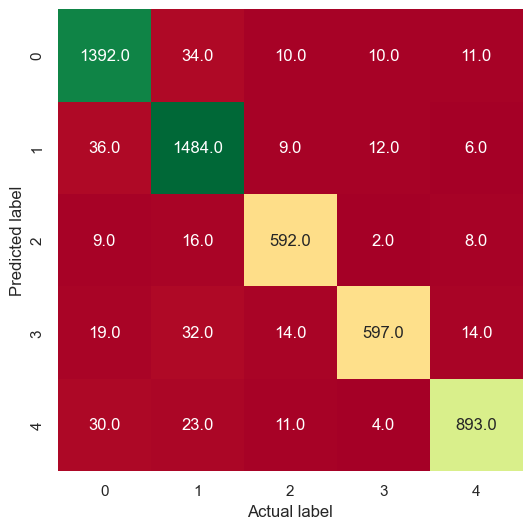

In [65]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [66]:
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.94      0.96      0.95      1457
Credit card / Prepaid card       0.93      0.96      0.95      1547
                    Others       0.93      0.94      0.94       627
   Theft/Dispute reporting       0.96      0.88      0.92       676
           Mortgages/loans       0.96      0.93      0.94       961

                  accuracy                           0.94      5268
                 macro avg       0.94      0.93      0.94      5268
              weighted avg       0.94      0.94      0.94      5268



- The overall accuracy of the logistic regression model is <b>94%</b>
- Both the precision and recall of the model is <b>94%</b>

### 2. Decision Tree

In [67]:
# Decision tree classifier
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
dt.score(X_test, y_test)

0.8014426727410782

#### Performing hyperparameter tuning

In [68]:
dt_grid = {"max_depth": np.arange(2, 20, 2),
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

# Setup grid hyperparameter search for LogisticRegression
dt_hpt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                param_grid=dt_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
dt_hpt.fit(X_train, y_train)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                         'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
             verbose=True)

In [69]:
# Check best parameters
dt_hpt.best_params_

{'max_depth': 18, 'min_samples_leaf': 11, 'min_samples_split': 2}

In [70]:
# Evaluating the tuned model
dt_hpt.score(X_test, y_test)

0.810554290053151

#### After tuning the hyperparamets, the accuracy of the model increased from <b>80.14%</b> to <b>81.05%</b>

In [71]:
# Make predictions on test data
y_pred = dt_hpt.predict(X_test)

In [72]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1221  105   51   23   57]
 [ 122 1283   35   60   47]
 [  32   38  487   13   57]
 [  34   85   23  494   40]
 [  62   48   50   16  785]]


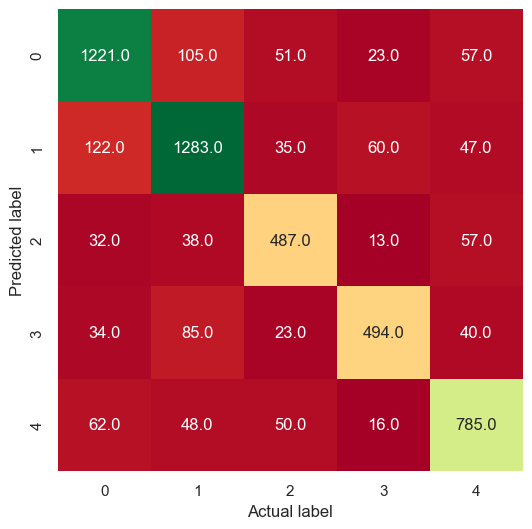

In [73]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [74]:
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.83      0.84      0.83      1457
Credit card / Prepaid card       0.82      0.83      0.83      1547
                    Others       0.75      0.78      0.77       627
   Theft/Dispute reporting       0.82      0.73      0.77       676
           Mortgages/loans       0.80      0.82      0.81       961

                  accuracy                           0.81      5268
                 macro avg       0.80      0.80      0.80      5268
              weighted avg       0.81      0.81      0.81      5268



- The overall accuracy of the decision tree is <b>81%</b>
- Both the precision and recall of the model is <b>81%</b>
- This is underperforming as compared to the logistic regrssion model

### 3. Random Forest Classifier

In [75]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
rf.score(X_test, y_test)

0.8209946848899012

#### Performing hyperparameter tuning

In [76]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": np.arange(2, 50, 2),
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48]),
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [77]:
rf_hpt.best_params_

{'n_estimators': 810,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 44}

In [78]:
rf_hpt.score(X_test, y_test)

0.8202353834472286

#### After tuning the hyperparamets, the accuracy of the model decreased from <b>82.1%</b> to <b>82.02%</b>

In [79]:
y_pred = rf_hpt.predict(X_test)

In [80]:
print(confusion_matrix(y_test, y_pred))

[[1345   91    2    9   10]
 [ 100 1436    1   10    0]
 [ 121  147  263   10   86]
 [  34  163    7  451   21]
 [  63   58    5    9  826]]


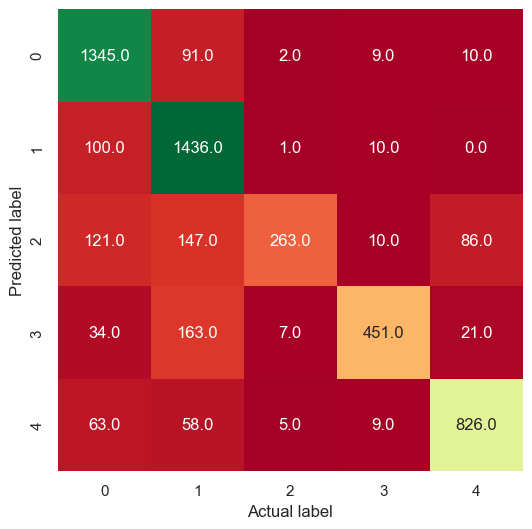

In [81]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [82]:
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.81      0.92      0.86      1457
Credit card / Prepaid card       0.76      0.93      0.83      1547
                    Others       0.95      0.42      0.58       627
   Theft/Dispute reporting       0.92      0.67      0.77       676
           Mortgages/loans       0.88      0.86      0.87       961

                  accuracy                           0.82      5268
                 macro avg       0.86      0.76      0.78      5268
              weighted avg       0.84      0.82      0.81      5268



- The overall accuracy of the random tree classifier is <b>81%</b>
- The precision of this model is <b>84%</b> whereas the recall of the model is <b>82%</b>
- The model performs better than the Decision tree classifier, however it underperforms as compared to the logistic regression model

### 4. Gaussian Naive Bayes

In [83]:
nb = GaussianNB().fit(X_train.toarray(), y_train)
nb.score(X_test.toarray(), y_test)

0.37813211845102507

In [84]:
y_pred = nb.predict(X_test.toarray())

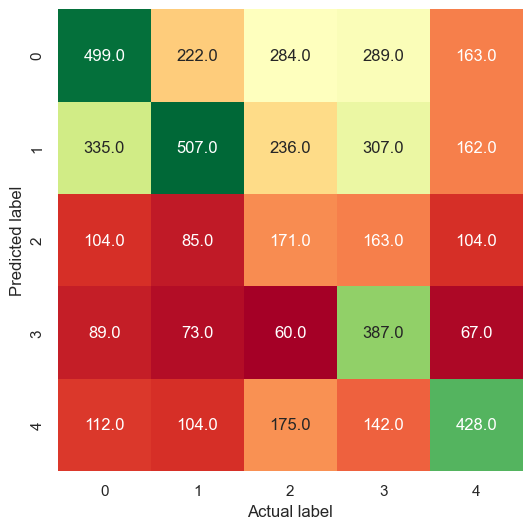

In [85]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [86]:
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.44      0.34      0.38      1457
Credit card / Prepaid card       0.51      0.33      0.40      1547
                    Others       0.18      0.27      0.22       627
   Theft/Dispute reporting       0.30      0.57      0.39       676
           Mortgages/loans       0.46      0.45      0.45       961

                  accuracy                           0.38      5268
                 macro avg       0.38      0.39      0.37      5268
              weighted avg       0.42      0.38      0.38      5268



- The overall accuracy of the Gaussian Naive Bayes model is <b>38%</b> which is better than a random coin toss for 5 classes
- The precision of this model is <b>42%</b> whereas the recall of the model is <b>38%</b>
- This model perfoms the worst as compared to all the other models

## Overall results

We created four supervised models to predict the topics based on the comments and belowe is a brief summary of it

#### <i>Logistic regression</i>
- After tuning the model, the precision, recall and the overall accuracy of the model is <b>94%</b>.
- The tuned model uses L1 penalty term with regularization strength (C) of 2

#### <i>Decision Tree classifier</i>
- After tuning the model, the precision, recall and the overall accuracy of the model is <b>81%</b>.
- The tuned model has max_depth of 18, min_samples_leaf of 11, min_samples_split of 2.

#### <i>Random forest classifier</i>
- After tuning the model, the overall accuracy of the model is <b>81%</b> with <b>84%</b> precision and <b>82%</b> recall.
- The tuned model uses:
    - n_estimators = 810,
    - min_samples_split = 4,
    - min_samples_leaf = 1,
    - max_depth = 44

#### <i>Gaussian Naive Bayes</i>
- The model has an overall accuracy of <b>38%</b>.
- The precision of this model is <b>42%</b> whereas the recall of the model is <b>38%</b>

## Results

#### Based on our experiment, Logistic regression turns out to be the best model with 94% accuracy, precision and recall.

## Inferring the best model

In [87]:
best_model = logreg_hpt

In [88]:
# Some sample complaints to infer model

df_complaints = pd.DataFrame({'complaints': [ "I want to open to open an account with the bank and I was not able to schedule a date.",
                                  "My account got charged with Uber eats 2 times when I ordered only once. My amount is till showing as pending even though it's been over a week. I want my mpney back",
                                  "I was not able to find the contact number of the nearest bank branch as I wanted to check the opening hours.",
                                  "I wish to raise an official complaint in respect of your treatment of my mortgage account on the basis that I do not believe that I have been treated fairly.My understanding of the basis of this mortgage was that the rate would only ever vary when the base rate changed. You now seem to be telling me that you are able to adjust the tracker rate margin too. Had I known about this I would have chosen another mortgage product/lender.",
                                  "I am writing to dispute a charge of $300 to my credit card account on 01/01/2023. The charge is in error because the items weren't delivered and I was overcharged",
                                  "My mortgage loan interest was supposed to be 12 APR but I am being charged at 15 APR.",
                                  "I noticed credit inquiries that i did not authorize made by chase credit card company.",
                                  "My credit card was billed $100 even though I hadn't used it in the last 2 months.",
                                  "There are late payment showing up on my credit card even though I had made all the payments"
                                ]
                            })
df_complaints

,complaints
0,I want to open to open an account with the ban...
1,My account got charged with Uber eats 2 times ...
2,I was not able to find the contact number of t...
3,I wish to raise an official complaint in respe...
4,I am writing to dispute a charge of $300 to my...
5,My mortgage loan interest was supposed to be 1...
6,I noticed credit inquiries that i did not auth...
7,My credit card was billed $100 even though I h...
8,There are late payment showing up on my credit...


In [89]:
def predict_lr(text, best_model, Topic_names):
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = best_model.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [90]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x], best_model, Topic_names))
df_complaints

,complaints,tag
0,I want to open to open an account with the ban...,Bank account services
1,My account got charged with Uber eats 2 times ...,Bank account services
2,I was not able to find the contact number of t...,Bank account services
3,I wish to raise an official complaint in respe...,Mortgages/loans
4,I am writing to dispute a charge of $300 to my...,Credit card / Prepaid card
5,My mortgage loan interest was supposed to be 1...,Mortgages/loans
6,I noticed credit inquiries that i did not auth...,Theft/Dispute reporting
7,My credit card was billed $100 even though I h...,Credit card / Prepaid card
8,There are late payment showing up on my credit...,Others


## It looks like all the sample complaints above were predicted correctly and we can conclude that the model works correctly.